In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data_cs/'
batch_size = 256
batch_num  = 128
epoch_num  = 200
samp_num   = 7

device = torch.device("cuda:1")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
def sample_subgraph(graph, time_range, sampled_depth = 2, sampled_number = 8, inp = None):
    '''
        Sample Sub-Graph based on the connection of other nodes with currently sampled nodes
        We maintain budgets for each node type, indexed by <node_id, time>.
        Currently sampled nodes are stored in layer_data.
        After nodes are sampled, we construct the sampled adjacancy matrix.
    '''
    layer_data  = defaultdict( #target_type
                        lambda: {} # {target_id: [ser, time]}
                    )
    budget     = defaultdict( #source_type
                                    lambda: defaultdict(  #source_id
                                        lambda: [0., 2000] #sampled_score, source_time
                            ))
    new_layer_adj  = defaultdict( #target_type
                                    lambda: defaultdict(  #source_type
                                        lambda: defaultdict(  #relation_type
                                            lambda: [] #[target_id, source_id]
                                )))
    '''
        For each node being sampled, we find out all its neighborhood, 
        adding the degree count of these nodes in the budget.
        Note that there exist some nodes that have many neighborhoods
        (such as fields, venues), for those case, we only consider 
    '''
    def add_budget(te, target_id, target_time, layer_data, budget):
        for source_type in te:
            tes = te[source_type]
            for relation_type in tes:
                if relation_type == 'self':
                    continue
                adl = tes[relation_type][target_id]
                if len(adl) < sampled_number:
                    sampled_ids = list(adl.keys())
                else:
                    sampled_ids = np.random.choice(list(adl.keys()), sampled_number, replace = False)
                for source_id in sampled_ids:
                    source_time = adl[source_id]
                    if source_time == None:
                        source_time = target_time
                    '''
                        If the node's time is out of range or already being sampled, skip
                        Otherwise, accumulate the normalized degree.
                    '''
                    if source_time not in time_range or source_id in layer_data[source_type]:
                        continue
                    budget[source_type][source_id][0] += 1. / len(sampled_ids)
                    budget[source_type][source_id][1] = source_time
    '''
        The encode and decode function is used to index each node
        by its node_id and time together. So that a same node with
        different timestamps can exist in the sampled graph.
    '''
    
    if inp == None:
        _time = np.random.choice(list(time_range.keys()))
        res = graph.node_feature['paper'][graph.node_feature['paper']['time'] == _time]
        sampn = min(len(res), sampled_number)
        rand_paper_ids  = np.random.choice(list(res.index), sampn, replace = False)
        '''
            First adding the sampled nodes then updating budget.
        '''
        for _id in rand_paper_ids:
            layer_data['paper'][_id] = [len(layer_data['paper']), _time]
        for _id in rand_paper_ids:
            add_budget(graph.edge_list['paper'], _id, _time, layer_data, budget)
    else:
        '''
            First adding the sampled nodes then updating budget.
        '''
        for _type in inp:
            for _id, _time in inp[_type]:
                layer_data[_type][_id] = [len(layer_data[_type]), _time]
        for _type in inp:
            te = graph.edge_list[_type]
            for _id, _time in inp[_type]:
                add_budget(te, _id, _time, layer_data, budget)
    '''
        We recursively expand the sampled graph by sampled_depth.
        Each time we sample a fixed number of nodes for each budget,
        based on the accumulated degree.
    '''
    for layer in range(sampled_depth):
        sts = list(budget.keys())
        for source_type in sts:
            te = graph.edge_list[source_type]
            keys  = np.array(list(budget[source_type].keys()))
            vals  = np.array(list(budget[source_type].values()))
            if sampled_number > len(keys):
                '''
                    Directly sample all the nodes
                '''
                sampled_ids = np.arange(len(keys))
            else:
                '''
                    Sample based on accumulated degree
                '''
                score = vals[:,0] ** 2
                score = score / np.sum(score)
                sampled_ids = np.random.choice(len(score), sampled_number, p = score, replace = False) 
            sampled_keys = keys[sampled_ids]
            sampled_tims = vals[sampled_ids][:, 1]
            '''
                First adding the sampled nodes then updating budget.
            '''
            for k, t in zip(sampled_keys, sampled_tims):
                layer_data[source_type][k] = [len(layer_data[source_type]), t]
            for k, t in zip(sampled_keys, sampled_tims):
                add_budget(te, int(k), int(t), layer_data, budget)
                budget[source_type].pop(k)    
    '''
        Prepare feature, time and adjacency matrix for the sampled graph
    '''
    feature = {}
    times   = {}
    indxs   = {}
    for _type in layer_data:
        idxs = []
        tims = []
        for k in layer_data[_type]:
            idxs += [k]
            tims += [layer_data[_type][k][1]]
        if 'node_emb' in graph.node_feature[_type]:
            feature[_type] = np.array(list(graph.node_feature['field'].loc[idxs, 'node_emb']), dtype=np.float)
        else:
            feature[_type] = np.zeros([len(layer_data[_type]), 400])
        feature[_type] = np.concatenate((feature[_type], list(graph.node_feature[_type].loc[idxs, 'emb']),\
            np.log10(np.array(list(graph.node_feature[_type].loc[idxs, 'citation'])).reshape(-1, 1) + 0.01)), axis=1)
        indxs[_type] = idxs
        times[_type] = tims
        
    edge_list = defaultdict( #target_type
                        lambda: defaultdict(  #source_type
                            lambda: defaultdict(  #relation_type
                                lambda: [] # [target_id, source_id] 
                                    )))
    for _type in layer_data:
        for _key in layer_data[_type]:
            _ser = layer_data[_type][_key][0]
            edge_list[_type][_type]['self'] += [[_ser, _ser]]
    '''
        Reconstruct sampled adjacancy matrix by checking whether each
        link exist in the original graph
    '''
    for target_type in graph.edge_list:
        te = graph.edge_list[target_type]
        for source_type in te:
            tes = te[source_type]
            for relation_type in tes:
#                 if relation_type in ['APA_coauthor', 'rev_APV_in', 'IPI_coauthor', 'APV_in']:
#                     continue
                tesr = tes[relation_type]
                for target_key in layer_data[target_type]:
                    target_ser = layer_data[target_type][target_key][0]
                    tesrt = tesr[target_key]
                    for source_key in layer_data[source_type]:
                        source_ser = layer_data[source_type][source_key][0]
                        '''
                            Check whether each link (target_id, source_id) exist in original adjacancy matrix
                        '''
                        if source_key in tesrt:
                            edge_list[target_type][source_type][relation_type] += [[target_ser, source_ser]]
    return feature, times, edge_list, indxs

In [4]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [5]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    sampn = min(len(papers[_time]), batch_size)
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), sampn, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
            edge[x_id][fids.index(f_id)] = True
    pids = np.stack([pids, np.repeat([_time], sampn)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list, _ = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'field': fids}, sampled_depth = 3, sampled_number = 100)

    el = []
    for i in edge_list['paper']['field']['rev_PF_in_L2']:
        if i[0] in edge and i[1] in edge[i[0]]:
            continue
        el += [i]
    edge_list['paper']['field']['rev_PF_in_L2'] = el

    el = []
    for i in edge_list['field']['paper']['PF_in_L2']:
        if i[1] in edge and i[0] in edge[i[1]]:
            continue
        el += [i]
    edge_list['field']['paper']['PF_in_L2'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list, graph)
    '''
        Trace the paper_id and field_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    field_ids = np.arange(len(fids)) + node_dict['field'][0]
    ylabel = torch.zeros(sampn, len(cand_list))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][cand_list.index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [6]:
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(RAGCNConv(n_hid, n_hid, num_types, num_relations, n_heads, dropout))
    def set_device(self, device):
        self.device = device
        for gc in self.gcs:
            gc.device = device
    def forward(self, node_feature, node_type, edge_time, edge_index, edge_type):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = gc(meta_xs, node_type, edge_index, edge_type, edge_time)
        return meta_xs

In [7]:
'''
Paper-Field
'''
paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in graph.edge_list['field']['paper']['PF_in_L2']:
    for p_id in graph.edge_list['field']['paper']['PF_in_L2'][f_id]:
        _time = graph.edge_list['field']['paper']['PF_in_L2'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size // 2:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size // 2:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size // 2:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))

In [8]:
types = graph.get_types()
cand_list = list(graph.edge_list['field']['paper']['PF_in_L2'])
gnn = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, num_types = len(types), \
          num_relations = len(graph.get_meta_graph()) + 1, n_heads = 8, n_layers = 3).to(device)
# gnn = torch.load('../pre-train/save/cpc_model.pt').to(device)
classifier = Classifier(256, len(cand_list)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

In [9]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 1500
best_val   = 0
res = []
criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(epoch_num)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    model.train()
    train_losses = []
    torch.cuda.empty_cache()
    for batch in np.arange(2):
        for node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            torch.cuda.empty_cache()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
            del res, loss
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                                   edge_time.to(device), edge_index.to(device), edge_type.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/rgt_2.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        del res, loss
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
            res  = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print(test_ndcg)
            del res
    del train_data, valid_data

Data Preparation: 47.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 (126.6s)  LR: 0.00060 Train Loss: 8.27  Valid Loss: 6.63  Valid NDCG: 0.2166
Data Preparation: 2.6s
Epoch: 2 (126.8s)  LR: 0.00069 Train Loss: 6.52  Valid Loss: 6.56  Valid NDCG: 0.2059
Data Preparation: 2.8s
Epoch: 3 (125.8s)  LR: 0.00078 Train Loss: 6.33  Valid Loss: 6.40  Valid NDCG: 0.2097
Data Preparation: 2.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 4 (124.3s)  LR: 0.00085 Train Loss: 6.28  Valid Loss: 6.45  Valid NDCG: 0.2245
Data Preparation: 3.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 5 (125.4s)  LR: 0.00091 Train Loss: 6.07  Valid Loss: 6.11  Valid NDCG: 0.2355
0.22592349509144
Data Preparation: 11.1s
Epoch: 6 (123.9s)  LR: 0.00096 Train Loss: 5.97  Valid Loss: 6.24  Valid NDCG: 0.2191
Data Preparation: 2.7s
Epoch: 7 (126.6s)  LR: 0.00099 Train Loss: 5.96  Valid Loss: 6.12  Valid NDCG: 0.2339
Data Preparation: 2.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 8 (128.5s)  LR: 0.00100 Train Loss: 5.87  Valid Loss: 6.29  Valid NDCG: 0.2393
Data Preparation: 2.7s
Epoch: 9 (124.4s)  LR: 0.00099 Train Loss: 5.83  Valid Loss: 6.39  Valid NDCG: 0.2303
Data Preparation: 2.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 10 (125.5s)  LR: 0.00096 Train Loss: 5.72  Valid Loss: 6.05  Valid NDCG: 0.2407
0.22979212578378033
Data Preparation: 11.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 (124.1s)  LR: 0.00092 Train Loss: 5.68  Valid Loss: 6.02  Valid NDCG: 0.2496
Data Preparation: 2.8s
Epoch: 12 (127.2s)  LR: 0.00086 Train Loss: 5.68  Valid Loss: 5.98  Valid NDCG: 0.2484
Data Preparation: 2.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 13 (126.1s)  LR: 0.00079 Train Loss: 5.62  Valid Loss: 5.79  Valid NDCG: 0.2564
Data Preparation: 2.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 14 (125.0s)  LR: 0.00070 Train Loss: 5.48  Valid Loss: 5.74  Valid NDCG: 0.2613
Data Preparation: 3.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 15 (125.2s)  LR: 0.00061 Train Loss: 5.40  Valid Loss: 5.81  Valid NDCG: 0.2744
0.27232746671980723
Data Preparation: 11.8s
Epoch: 16 (124.2s)  LR: 0.00051 Train Loss: 5.43  Valid Loss: 5.85  Valid NDCG: 0.2492
Data Preparation: 3.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 17 (127.5s)  LR: 0.00042 Train Loss: 5.35  Valid Loss: 5.65  Valid NDCG: 0.2800
Data Preparation: 2.8s
Epoch: 18 (126.9s)  LR: 0.00032 Train Loss: 5.34  Valid Loss: 5.71  Valid NDCG: 0.2704
Data Preparation: 2.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 19 (125.2s)  LR: 0.00024 Train Loss: 5.38  Valid Loss: 5.53  Valid NDCG: 0.2933
Data Preparation: 2.8s
Epoch: 20 (125.1s)  LR: 0.00016 Train Loss: 5.30  Valid Loss: 5.59  Valid NDCG: 0.2797
0.25240370190001477
Data Preparation: 11.3s
Epoch: 21 (126.3s)  LR: 0.00009 Train Loss: 5.34  Valid Loss: 5.67  Valid NDCG: 0.2679
Data Preparation: 3.0s
Epoch: 22 (126.4s)  LR: 0.00005 Train Loss: 5.29  Valid Loss: 5.57  Valid NDCG: 0.2916
Data Preparation: 2.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 23 (149.1s)  LR: 0.00001 Train Loss: 5.25  Valid Loss: 5.50  Valid NDCG: 0.2938
Data Preparation: 3.1s
Epoch: 24 (155.3s)  LR: 0.00000 Train Loss: 5.26  Valid Loss: 5.57  Valid NDCG: 0.2751
Data Preparation: 3.0s
Epoch: 25 (152.7s)  LR: 0.00001 Train Loss: 5.29  Valid Loss: 5.44  Valid NDCG: 0.2910
0.23294595776137314
Data Preparation: 12.3s
Epoch: 26 (154.9s)  LR: 0.00003 Train Loss: 5.26  Valid Loss: 5.57  Valid NDCG: 0.2830
Data Preparation: 2.9s
Epoch: 27 (153.9s)  LR: 0.00007 Train Loss: 5.30  Valid Loss: 5.63  Valid NDCG: 0.2798
Data Preparation: 2.9s
Epoch: 28 (157.4s)  LR: 0.00013 Train Loss: 5.34  Valid Loss: 5.62  Valid NDCG: 0.2858
Data Preparation: 3.9s
Epoch: 29 (159.6s)  LR: 0.00020 Train Loss: 5.32  Valid Loss: 5.49  Valid NDCG: 0.2879
Data Preparation: 3.5s
Epoch: 30 (156.7s)  LR: 0.00029 Train Loss: 5.24  Valid Loss: 5.71  Valid NDCG: 0.2923
0.286011903453983
Data Preparation: 11.6s
Epoch: 31 (151.8s)  LR: 0.00038 Train Loss: 5.22  Valid Loss: 5.48  Valid NDCG: 

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 32 (157.3s)  LR: 0.00048 Train Loss: 5.18  Valid Loss: 5.45  Valid NDCG: 0.3035
Data Preparation: 3.4s
Epoch: 33 (159.8s)  LR: 0.00057 Train Loss: 5.21  Valid Loss: 5.47  Valid NDCG: 0.2903
Data Preparation: 2.8s
Epoch: 34 (152.8s)  LR: 0.00067 Train Loss: 5.11  Valid Loss: 5.50  Valid NDCG: 0.2948
Data Preparation: 3.0s
Epoch: 35 (150.5s)  LR: 0.00075 Train Loss: 5.10  Valid Loss: 5.44  Valid NDCG: 0.3010
0.29104203899359055
Data Preparation: 13.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 36 (154.1s)  LR: 0.00083 Train Loss: 5.13  Valid Loss: 5.33  Valid NDCG: 0.3173
Data Preparation: 3.5s
Epoch: 37 (154.5s)  LR: 0.00090 Train Loss: 5.11  Valid Loss: 5.32  Valid NDCG: 0.2978
Data Preparation: 3.1s
Epoch: 38 (152.7s)  LR: 0.00095 Train Loss: 4.99  Valid Loss: 5.41  Valid NDCG: 0.3112
Data Preparation: 3.8s
Epoch: 39 (156.1s)  LR: 0.00098 Train Loss: 5.01  Valid Loss: 5.25  Valid NDCG: 0.3105
Data Preparation: 3.0s
Epoch: 40 (159.4s)  LR: 0.00100 Train Loss: 5.00  Valid Loss: 5.36  Valid NDCG: 0.2833
0.2749817219340351
Data Preparation: 11.7s
Epoch: 41 (153.7s)  LR: 0.00100 Train Loss: 4.99  Valid Loss: 5.19  Valid NDCG: 0.3085
Data Preparation: 3.0s
Epoch: 42 (157.0s)  LR: 0.00097 Train Loss: 4.90  Valid Loss: 5.36  Valid NDCG: 0.2927
Data Preparation: 3.2s
Epoch: 43 (155.6s)  LR: 0.00093 Train Loss: 4.94  Valid Loss: 5.64  Valid NDCG: 0.2885
Data Preparation: 3.1s
Epoch: 44 (154.9s)  LR: 0.00088 Train Loss: 4.87  Valid Loss: 5.29  Valid NDCG: 0.3126
Data Preparat

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 51 (151.9s)  LR: 0.00026 Train Loss: 4.70  Valid Loss: 5.13  Valid NDCG: 0.3243
Data Preparation: 3.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 52 (154.3s)  LR: 0.00018 Train Loss: 4.69  Valid Loss: 4.89  Valid NDCG: 0.3417
Data Preparation: 3.4s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 53 (158.7s)  LR: 0.00011 Train Loss: 4.83  Valid Loss: 4.95  Valid NDCG: 0.3449
Data Preparation: 3.0s
Epoch: 54 (152.0s)  LR: 0.00006 Train Loss: 4.72  Valid Loss: 5.13  Valid NDCG: 0.3212
Data Preparation: 3.1s
Epoch: 55 (153.4s)  LR: 0.00002 Train Loss: 4.67  Valid Loss: 5.15  Valid NDCG: 0.3300
0.32055603712666525
Data Preparation: 13.8s
Epoch: 56 (157.8s)  LR: 0.00000 Train Loss: 4.80  Valid Loss: 5.04  Valid NDCG: 0.3308
Data Preparation: 3.2s
Epoch: 57 (151.4s)  LR: 0.00000 Train Loss: 4.66  Valid Loss: 5.16  Valid NDCG: 0.3189
Data Preparation: 3.0s
Epoch: 58 (153.2s)  LR: 0.00002 Train Loss: 4.78  Valid Loss: 5.14  Valid NDCG: 0.3124
Data Preparation: 3.0s
Epoch: 59 (157.3s)  LR: 0.00006 Train Loss: 4.70  Valid Loss: 5.01  Valid NDCG: 0.3309
Data Preparation: 3.7s
Epoch: 60 (156.7s)  LR: 0.00012 Train Loss: 4.72  Valid Loss: 5.16  Valid NDCG: 0.3206
0.24086194698986607
Data Preparation: 11.4s
Epoch: 61 (150.6s)  LR: 0.00018 Train Loss: 4.72  Valid Loss: 5.10  Valid NDCG

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 68 (152.3s)  LR: 0.00081 Train Loss: 4.74  Valid Loss: 5.12  Valid NDCG: 0.3463
Data Preparation: 3.0s
Epoch: 69 (155.4s)  LR: 0.00088 Train Loss: 4.72  Valid Loss: 5.20  Valid NDCG: 0.3296
Data Preparation: 3.2s
Epoch: 70 (156.5s)  LR: 0.00094 Train Loss: 4.61  Valid Loss: 5.03  Valid NDCG: 0.3271
0.2905511455214794
Data Preparation: 13.7s
Epoch: 71 (155.4s)  LR: 0.00098 Train Loss: 4.63  Valid Loss: 5.05  Valid NDCG: 0.3190
Data Preparation: 2.9s
Epoch: 72 (152.4s)  LR: 0.00100 Train Loss: 4.56  Valid Loss: 5.13  Valid NDCG: 0.3223
Data Preparation: 3.1s
Epoch: 73 (160.2s)  LR: 0.00100 Train Loss: 4.66  Valid Loss: 5.05  Valid NDCG: 0.3343
Data Preparation: 3.0s
Epoch: 74 (156.5s)  LR: 0.00098 Train Loss: 4.70  Valid Loss: 5.01  Valid NDCG: 0.3338
Data Preparation: 3.1s
Epoch: 75 (157.0s)  LR: 0.00095 Train Loss: 4.69  Valid Loss: 5.15  Valid NDCG: 0.3236
0.27222233979057603
Data Preparation: 12.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 76 (154.9s)  LR: 0.00089 Train Loss: 4.61  Valid Loss: 4.97  Valid NDCG: 0.3474
Data Preparation: 3.2s
Epoch: 77 (155.2s)  LR: 0.00083 Train Loss: 4.52  Valid Loss: 5.32  Valid NDCG: 0.3175
Data Preparation: 3.0s
Epoch: 78 (148.8s)  LR: 0.00075 Train Loss: 4.51  Valid Loss: 5.16  Valid NDCG: 0.3294
Data Preparation: 3.1s
Epoch: 79 (154.1s)  LR: 0.00066 Train Loss: 4.58  Valid Loss: 5.06  Valid NDCG: 0.3328
Data Preparation: 3.3s
Epoch: 80 (155.2s)  LR: 0.00056 Train Loss: 4.57  Valid Loss: 5.03  Valid NDCG: 0.3400
0.2599482652988351
Data Preparation: 13.1s
Epoch: 81 (154.5s)  LR: 0.00047 Train Loss: 4.48  Valid Loss: 5.00  Valid NDCG: 0.3356
Data Preparation: 3.1s
Epoch: 82 (152.3s)  LR: 0.00037 Train Loss: 4.64  Valid Loss: 5.00  Valid NDCG: 0.3318
Data Preparation: 3.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 83 (157.1s)  LR: 0.00028 Train Loss: 4.53  Valid Loss: 4.94  Valid NDCG: 0.3506
Data Preparation: 4.0s
Epoch: 84 (157.2s)  LR: 0.00020 Train Loss: 4.50  Valid Loss: 5.04  Valid NDCG: 0.3298
Data Preparation: 3.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 85 (153.8s)  LR: 0.00013 Train Loss: 4.44  Valid Loss: 4.82  Valid NDCG: 0.3606
0.2662263535318294
Data Preparation: 11.6s
Epoch: 86 (152.6s)  LR: 0.00007 Train Loss: 4.36  Valid Loss: 4.75  Valid NDCG: 0.3553
Data Preparation: 3.7s
Epoch: 87 (158.2s)  LR: 0.00003 Train Loss: 4.43  Valid Loss: 5.09  Valid NDCG: 0.3513
Data Preparation: 3.8s
Epoch: 88 (156.1s)  LR: 0.00001 Train Loss: 4.51  Valid Loss: 5.13  Valid NDCG: 0.3248
Data Preparation: 3.2s
Epoch: 89 (155.7s)  LR: 0.00000 Train Loss: 4.49  Valid Loss: 4.88  Valid NDCG: 0.3466
Data Preparation: 3.4s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 90 (162.3s)  LR: 0.00002 Train Loss: 4.51  Valid Loss: 4.72  Valid NDCG: 0.3674
0.28904805696158176
Data Preparation: 13.6s
Epoch: 91 (159.1s)  LR: 0.00005 Train Loss: 4.50  Valid Loss: 4.92  Valid NDCG: 0.3482
Data Preparation: 3.3s
Epoch: 92 (151.4s)  LR: 0.00010 Train Loss: 4.31  Valid Loss: 4.98  Valid NDCG: 0.3362
Data Preparation: 3.3s
Epoch: 93 (150.8s)  LR: 0.00017 Train Loss: 4.33  Valid Loss: 4.96  Valid NDCG: 0.3560
Data Preparation: 3.4s
Epoch: 94 (155.8s)  LR: 0.00024 Train Loss: 4.37  Valid Loss: 5.01  Valid NDCG: 0.3418
Data Preparation: 3.6s
Epoch: 95 (152.6s)  LR: 0.00033 Train Loss: 4.35  Valid Loss: 4.91  Valid NDCG: 0.3512
0.3112266243285944
Data Preparation: 12.1s
Epoch: 96 (151.4s)  LR: 0.00043 Train Loss: 4.33  Valid Loss: 5.01  Valid NDCG: 0.3349
Data Preparation: 3.7s
Epoch: 97 (156.0s)  LR: 0.00052 Train Loss: 4.44  Valid Loss: 4.89  Valid NDCG: 0.3471
Data Preparation: 3.2s
Epoch: 98 (160.1s)  LR: 0.00062 Train Loss: 4.33  Valid Loss: 4.99  Valid NDCG:

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 116 (129.2s)  LR: 0.00022 Train Loss: 4.24  Valid Loss: 4.74  Valid NDCG: 0.3785
Data Preparation: 3.3s
Epoch: 117 (135.9s)  LR: 0.00014 Train Loss: 4.40  Valid Loss: 4.72  Valid NDCG: 0.3741
Data Preparation: 3.4s
Epoch: 118 (135.4s)  LR: 0.00008 Train Loss: 4.14  Valid Loss: 5.14  Valid NDCG: 0.3217
Data Preparation: 3.4s
Epoch: 119 (148.1s)  LR: 0.00004 Train Loss: 4.25  Valid Loss: 4.71  Valid NDCG: 0.3549
Data Preparation: 3.5s
Epoch: 120 (157.0s)  LR: 0.00001 Train Loss: 4.24  Valid Loss: 4.83  Valid NDCG: 0.3620
0.32099769081312607
Data Preparation: 11.8s
Epoch: 121 (141.2s)  LR: 0.00000 Train Loss: 4.43  Valid Loss: 5.00  Valid NDCG: 0.3518
Data Preparation: 3.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 122 (152.9s)  LR: 0.00001 Train Loss: 4.27  Valid Loss: 4.79  Valid NDCG: 0.3827
Data Preparation: 3.6s
Epoch: 123 (141.6s)  LR: 0.00004 Train Loss: 4.34  Valid Loss: 4.84  Valid NDCG: 0.3559
Data Preparation: 3.3s
Epoch: 124 (156.5s)  LR: 0.00009 Train Loss: 4.29  Valid Loss: 4.95  Valid NDCG: 0.3341
Data Preparation: 3.6s
Epoch: 125 (144.0s)  LR: 0.00015 Train Loss: 4.06  Valid Loss: 4.69  Valid NDCG: 0.3616
0.349726625721841
Data Preparation: 12.6s
Epoch: 126 (151.5s)  LR: 0.00022 Train Loss: 4.30  Valid Loss: 4.75  Valid NDCG: 0.3766
Data Preparation: 3.4s
Epoch: 127 (150.7s)  LR: 0.00031 Train Loss: 4.05  Valid Loss: 4.88  Valid NDCG: 0.3568
Data Preparation: 3.4s
Epoch: 128 (142.3s)  LR: 0.00040 Train Loss: 4.23  Valid Loss: 4.90  Valid NDCG: 0.3514
Data Preparation: 3.6s
Epoch: 129 (157.0s)  LR: 0.00050 Train Loss: 4.21  Valid Loss: 4.71  Valid NDCG: 0.3795
Data Preparation: 3.7s
Epoch: 130 (139.9s)  LR: 0.00059 Train Loss: 4.05  Valid Loss: 5.01  Valid NDCG: 0.3400
0.314

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 139 (143.2s)  LR: 0.00097 Train Loss: 4.21  Valid Loss: 4.65  Valid NDCG: 0.3857
Data Preparation: 3.7s
Epoch: 140 (152.2s)  LR: 0.00092 Train Loss: 4.09  Valid Loss: 4.74  Valid NDCG: 0.3792
0.3420544418620318
Data Preparation: 12.9s
Epoch: 141 (144.9s)  LR: 0.00086 Train Loss: 4.18  Valid Loss: 4.87  Valid NDCG: 0.3661
Data Preparation: 3.4s
Epoch: 142 (149.7s)  LR: 0.00079 Train Loss: 4.18  Valid Loss: 5.00  Valid NDCG: 0.3468
Data Preparation: 3.6s
Epoch: 143 (152.1s)  LR: 0.00070 Train Loss: 4.07  Valid Loss: 4.86  Valid NDCG: 0.3500
Data Preparation: 3.6s
Epoch: 144 (137.7s)  LR: 0.00061 Train Loss: 3.99  Valid Loss: 4.85  Valid NDCG: 0.3644
Data Preparation: 3.6s
Epoch: 145 (155.3s)  LR: 0.00052 Train Loss: 4.05  Valid Loss: 5.00  Valid NDCG: 0.3432
0.2933615051188384
Data Preparation: 14.3s
Epoch: 146 (137.6s)  LR: 0.00042 Train Loss: 4.09  Valid Loss: 4.72  Valid NDCG: 0.3794
Data Preparation: 3.6s
Epoch: 147 (156.0s)  LR: 0.00033 Train Loss: 4.21  Valid Loss: 4.89  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 160 (141.7s)  LR: 0.00038 Train Loss: 4.11  Valid Loss: 4.68  Valid NDCG: 0.3865
0.3319371851237367
Data Preparation: 13.3s
Epoch: 161 (158.8s)  LR: 0.00047 Train Loss: 4.29  Valid Loss: 4.81  Valid NDCG: 0.3567
Data Preparation: 3.4s
Epoch: 162 (143.1s)  LR: 0.00057 Train Loss: 4.04  Valid Loss: 4.84  Valid NDCG: 0.3567
Data Preparation: 3.6s
Epoch: 163 (153.5s)  LR: 0.00066 Train Loss: 4.13  Valid Loss: 4.83  Valid NDCG: 0.3541
Data Preparation: 3.6s
Epoch: 164 (147.3s)  LR: 0.00075 Train Loss: 3.96  Valid Loss: 4.97  Valid NDCG: 0.3574
Data Preparation: 3.6s
Epoch: 165 (145.6s)  LR: 0.00083 Train Loss: 4.11  Valid Loss: 4.71  Valid NDCG: 0.3582
0.3337900829705448
Data Preparation: 14.2s
Epoch: 166 (154.9s)  LR: 0.00090 Train Loss: 4.08  Valid Loss: 4.85  Valid NDCG: 0.3607
Data Preparation: 3.6s
Epoch: 167 (140.6s)  LR: 0.00095 Train Loss: 3.92  Valid Loss: 4.83  Valid NDCG: 0.3546
Data Preparation: 3.4s
Epoch: 168 (155.4s)  LR: 0.00098 Train Loss: 3.98  Valid Loss: 4.98  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 191 (154.1s)  LR: 0.00026 Train Loss: 4.23  Valid Loss: 4.63  Valid NDCG: 0.3902
Data Preparation: 3.4s
Epoch: 192 (142.7s)  LR: 0.00035 Train Loss: 4.08  Valid Loss: 4.81  Valid NDCG: 0.3600
Data Preparation: 3.8s
Epoch: 193 (158.0s)  LR: 0.00045 Train Loss: 4.07  Valid Loss: 4.82  Valid NDCG: 0.3826
Data Preparation: 3.5s
Epoch: 194 (141.2s)  LR: 0.00054 Train Loss: 3.99  Valid Loss: 4.88  Valid NDCG: 0.3453
Data Preparation: 3.3s
Epoch: 195 (152.6s)  LR: 0.00064 Train Loss: 4.07  Valid Loss: 4.62  Valid NDCG: 0.3766
0.3184646946622827
Data Preparation: 12.9s
Epoch: 196 (145.5s)  LR: 0.00073 Train Loss: 3.98  Valid Loss: 4.74  Valid NDCG: 0.3643
Data Preparation: 3.3s
Epoch: 197 (152.3s)  LR: 0.00081 Train Loss: 4.12  Valid Loss: 4.64  Valid NDCG: 0.3887
Data Preparation: 3.6s
Epoch: 198 (149.7s)  LR: 0.00088 Train Loss: 4.19  Valid Loss: 4.95  Valid NDCG: 0.3423
Data Preparation: 3.6s
Epoch: 199 (147.4s)  LR: 0.00094 Train Loss: 4.10  Valid Loss: 4.77  Valid NDCG: 0.3584
Data

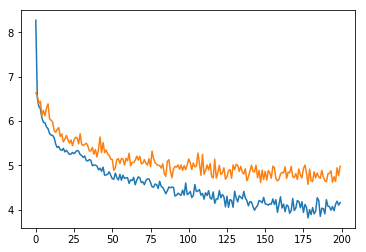

In [10]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [11]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.3206365488774218 0.026781741383400094
0.3077314998810093 0.12804626011727066


In [14]:
best_model = torch.load('./save/rgt_2.pt')

In [15]:
best_model.eval()
gnn, classifier = best_model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                      edge_time.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.30417195652757817 0.02610011738155658
0.30119136963691334 0.13802594600203896
